In [1]:
import numpy as np
# import gym
from tqdm import tqdm
import random
# import rl_utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import collections 

In [2]:
import argparse
import errno
import os
import random
from importlib.metadata import requires
from timeit import timeit
import dill as pickle
import numpy as np
import scipy
import torch
import wandb
import yaml
from sympy import Matrix, MatrixSymbol, derive_by_array, symarray
from torch.distributions import Categorical

from environment import GridWorld
from subrl.utils.network import append_state
from subrl.utils.network import policy as agent_net
from subrl.utils.visualization import Visu

In [3]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [4]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class QValueNet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
class CQL:
    ''' 处理离散动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 alpha_lr, target_entropy, tau, gamma, device, beta, num_random):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 第一个Q网络
        self.critic_1 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        # 第二个Q网络
        self.critic_2 = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_critic_1 = QValueNet(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNet(state_dim, hidden_dim,
                                         action_dim).to(device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

        self.beta = beta  # CQL损失函数中的系数
        self.num_random = num_random  # CQL中的动作采样数
        self.action_dim = action_dim  # 动作空间的维度

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    # 计算目标Q值,直接用策略网络的输出概率进行期望计算
    def calc_target(self, rewards, next_states, dones):
        next_probs = self.actor(next_states)
        next_log_probs = torch.log(next_probs + 1e-8)
        entropy = -torch.sum(next_probs * next_log_probs, dim=1, keepdim=True)
        q1_value = self.target_critic_1(next_states)
        q2_value = self.target_critic_2(next_states)
        min_qvalue = torch.sum(next_probs * torch.min(q1_value, q2_value),
                               dim=1,
                               keepdim=True)
        next_value = min_qvalue + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)  # 动作不再是float类型
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_q_values = self.critic_1(states).gather(1, actions)
        critic_1_loss = torch.mean(
            F.mse_loss(critic_1_q_values, td_target.detach()))
        critic_2_q_values = self.critic_2(states).gather(1, actions)
        critic_2_loss = torch.mean(
            F.mse_loss(critic_2_q_values, td_target.detach()))
        
        # 以上与SAC相同,以下Q网络更新是CQL的额外部分
        batch_size = states.shape[0]
        # 1. 均匀分布的动作
        # random_unif_actions =  torch.tensor(np.random.randint(0, self.action_dim, size=(batch_size*self.num_random,1)),
        #                                       dtype=torch.long).to(self.device)
        random_unif_actions = torch.arange(0, self.action_dim, device=self.device).long().repeat(batch_size).view(-1, 1)
        random_unif_log_pi = np.log(1.0 / self.action_dim)

        # 扩展状态维度（对应连续版本的tmp_states）
        tmp_states = states.unsqueeze(1).repeat(1, self.num_random, 1).view(-1, states.shape[-1])
        tmp_next_states = next_states.unsqueeze(1).repeat(1, self.num_random, 1).view(-1, next_states.shape[-1])

        #获取当前的动作
        random_curr_pi = self.actor(tmp_states)
        random_curr_actions_dist = torch.distributions.Categorical(random_curr_pi)
        random_curr_actions = random_curr_actions_dist.sample().unsqueeze(1)
        random_curr_log_pi = torch.log(random_curr_pi.gather(1, random_curr_actions))
        #获取下一个动作
        random_next_pi = self.actor(tmp_next_states)
        random_next_actions_dist = torch.distributions.Categorical(random_next_pi)
        random_next_actions = random_next_actions_dist.sample().unsqueeze(1)
        random_next_log_pi = torch.log(random_next_pi.gather(1, random_next_actions))

        q1_unif = self.critic_1(tmp_states).gather(1, random_unif_actions).view(-1, self.num_random, 1)
        q2_unif = self.critic_2(tmp_states).gather(1, random_unif_actions).view(-1, self.num_random, 1)

        q1_curr = self.critic_1(tmp_states).gather(1, random_curr_actions).view(-1, self.num_random, 1)
        q2_curr = self.critic_2(tmp_states).gather(1, random_curr_actions).view(-1, self.num_random, 1)

        q1_next = self.critic_1(tmp_states).gather(1, random_next_actions).view(-1, self.num_random, 1)
        q2_next = self.critic_2(tmp_states).gather(1, random_next_actions).view(-1, self.num_random, 1)

        q1_cat = torch.cat([
            q1_unif - random_unif_log_pi,
            q1_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q1_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ],dim=1)


        q2_cat = torch.cat([
            q2_unif - random_unif_log_pi,
            q2_curr - random_curr_log_pi.detach().view(-1, self.num_random, 1),
            q2_next - random_next_log_pi.detach().view(-1, self.num_random, 1)
        ],dim=1)

        qf1_loss_1 = torch.logsumexp(q1_cat, dim=1).mean()
        qf2_loss_1 = torch.logsumexp(q2_cat, dim=1).mean()
        qf1_loss_2 = self.critic_1(states).gather(1, actions).mean()
        qf2_loss_2 = self.critic_2(states).gather(1, actions).mean()
        qf1_loss = critic_1_loss + self.beta * (qf1_loss_1 - qf1_loss_2)
        qf2_loss = critic_2_loss + self.beta * (qf2_loss_1 - qf2_loss_2)

        self.critic_1_optimizer.zero_grad()
        qf1_loss.backward(retain_graph=True)
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        qf2_loss.backward(retain_graph=True)
        self.critic_2_optimizer.step()

        # 更新策略网络
        probs = self.actor(states)
        log_probs = torch.log(probs + 1e-8)
        # 直接根据概率计算熵
        entropy = -torch.sum(probs * log_probs, dim=1, keepdim=True)  #
        q1_value = self.critic_1(states)
        q2_value = self.critic_2(states)
        min_qvalue = torch.sum(probs * torch.min(q1_value, q2_value),
                               dim=1,
                               keepdim=True)  # 直接根据概率计算期望
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy - min_qvalue)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

In [5]:
buffer_size = 100000
replay_buffer = ReplayBuffer(buffer_size)

In [6]:
workspace = "subrl"

params = {
    "env": {
        "start": 1,
        "step_size": 0.1,
        "shape": {"x": 11, "y": 18},
        "horizon": 80,
        "node_weight": "constant",
        "disc_size": "small",
        "n_players": 3,
        "Cx_lengthscale": 2,
        "Cx_noise": 0.001,
        "Fx_lengthscale": 1,
        "Fx_noise": 0.001,
        "Cx_beta": 1.5,
        "Fx_beta": 1.5,
        "generate": False,
        "env_file_name": 'env_data.pkl',
        "cov_module": 'Matern',
        "stochasticity": 0.0,
        "domains": "two_room_2",
        "num": 1,  # 替代原来的args.env
        "initial": 80
    },
    "alg": {
        "gamma": 1,
        "type": "NM",
        "ent_coef": 0.0,
        "epochs": 140,
        "lr": 0.02
    },
    "common": {
        "a": 1,
        "subgrad": "greedy",
        "grad": "pytorch",
        "algo": "both",
        "init": "deterministic",
        "batch_size": 3000
    },
    "visu": {
        "wb": "disabled",
        "a": 1
    }
}

print(params)

# 2) Set the path and copy params from file
env_load_path = workspace + \
    "/environments/" + params["env"]["node_weight"]+ "/env_" + \
    str(params["env"]["num"])



epochs = params["alg"]["epochs"]

H = params["env"]["horizon"]
MAX_Ret = 2*(H+1)
if params["env"]["disc_size"] == "large":
    MAX_Ret = 3*(H+2)

# 3) Setup the environement
env = GridWorld(
    env_params=params["env"], common_params=params["common"], visu_params=params["visu"], env_file_path=env_load_path)
node_size = params["env"]["shape"]['x']*params["env"]["shape"]['y']
# TransitionMatrix = torch.zeros(node_size, node_size)

if params["env"]["node_weight"] == "entropy" or params["env"]["node_weight"] == "steiner_covering" or params["env"]["node_weight"] == "GP": 
    a_file = open(env_load_path +".pkl", "rb")
    data = pickle.load(a_file)
    a_file.close()

if params["env"]["node_weight"] == "entropy":
    env.cov = data
if params["env"]["node_weight"] == "steiner_covering":
    env.items_loc = data
if params["env"]["node_weight"] == "GP":
    env.weight = data

visu = Visu(env_params=params["env"])

env.get_horizon_transition_matrix()


{'env': {'start': 1, 'step_size': 0.1, 'shape': {'x': 11, 'y': 18}, 'horizon': 80, 'node_weight': 'constant', 'disc_size': 'small', 'n_players': 3, 'Cx_lengthscale': 2, 'Cx_noise': 0.001, 'Fx_lengthscale': 1, 'Fx_noise': 0.001, 'Cx_beta': 1.5, 'Fx_beta': 1.5, 'generate': False, 'env_file_name': 'env_data.pkl', 'cov_module': 'Matern', 'stochasticity': 0.0, 'domains': 'two_room_2', 'num': 1, 'initial': 80}, 'alg': {'gamma': 1, 'type': 'NM', 'ent_coef': 0.0, 'epochs': 140, 'lr': 0.02}, 'common': {'a': 1, 'subgrad': 'greedy', 'grad': 'pytorch', 'algo': 'both', 'init': 'deterministic', 'batch_size': 3000}, 'visu': {'wb': 'disabled', 'a': 1}}
x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.499

In [7]:
def sample_excellent_trajectories(filepath="two_Room_80_go_explore_archive_file.pkl", 
                                  method='top_n', 
                                  n=10, 
                                  p=0.1, 
                                  threshold=0):
    """
        Load data from the Go-Explore archive and sample high-quality trajectories based on the specified method.

        Args:
            filepath (str): Path to the .pkl archive file.
            method (str): Sampling method. Options are 'top_n', 'top_p', or 'threshold'.
            n (int): Number of trajectories to sample for the 'top_n' method.
            p (float): Percentage of top trajectories to sample for the 'top_p' method (e.g., 0.1 means top 10%).
            threshold (float): Minimum reward threshold for the 'threshold' method.
        
        Returns:
            list: A list of trajectory dictionaries with high rewards, sorted in descending order of reward.
                  Returns an empty list if the file does not exist or the archive is empty.
    """
    # 1. Check if the file exists and load the data
    if not os.path.exists(filepath):
        print(f"Error: Archive file not found '{filepath}'")
        return []
    
    try:
        with open(filepath, "rb") as f:
            archive = pickle.load(f)
        if not archive:
            print("警告：存檔庫為空。")
            return []
    except Exception as e:
        print(f"讀取文件時出錯: {e}")
        return []

    # 2. 提取所有軌跡數據並按獎勵排序
    # archive.values() 返回的是包含 reward, states, actions 等信息的字典
    all_trajectories_data = list(archive.values())
    
    # 按 'reward' 鍵從高到低排序
    all_trajectories_data.sort(key=lambda x: x['reward'], reverse=True)

    # 3. 根據指定方法進行採樣
    sampled_trajectories = []
    if method == 'top_n':
        # 取獎勵最高的前 N 條
        num_to_sample = min(n, len(all_trajectories_data))
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-N。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的 {len(sampled_trajectories)} 條。")

    elif method == 'top_p':
        # 取獎勵最高的前 P%
        if not (0 < p <= 1):
            print("錯誤：百分比 'p' 必須在 (0, 1] 之間。")
            return []
        num_to_sample = int(len(all_trajectories_data) * p)
        sampled_trajectories = all_trajectories_data[:num_to_sample]
        print(f"方法: Top-P。從 {len(all_trajectories_data)} 條軌跡中篩選出最好的前 {p*100:.1f}% ({len(sampled_trajectories)} 條)。")

    elif method == 'threshold':
        # 取獎勵高於指定門檻的所有軌跡
        sampled_trajectories = [data for data in all_trajectories_data if data['reward'] >= threshold]
        print(f"方法: Threshold。從 {len(all_trajectories_data)} 條軌跡中篩選出 {len(sampled_trajectories)} 條獎勵不低於 {threshold} 的軌跡。")
        
    else:
        print(f"錯誤：未知的採樣方法 '{method}'。請使用 'top_n', 'top_p', 或 'threshold'。")

    return sampled_trajectories


In [8]:
top_20_trajectories = sample_excellent_trajectories(method='top_n', n=20)
if top_20_trajectories:
    print(f"其中最好的一條獎勵為: {top_20_trajectories[0]['reward']}")
    print(f"最差的一條（在這20條中）獎勵為: {top_20_trajectories[-1]['reward']}\n")

方法: Top-N。從 5202 條軌跡中篩選出最好的 20 條。
其中最好的一條獎勵為: 137
最差的一條（在這20條中）獎勵為: 137



In [9]:
len(top_20_trajectories[-1]['states'])

79

In [10]:
def expand_trajectory_states(trajectory_states, H):
    """
    将轨迹状态按照 append_state 的方式进行拓展
    
    Args:
        trajectory_states: 轨迹中的状态列表
        H: 时间范围参数
        
    Returns:
        expanded_states: 拓展后的状态列表
    """
    expanded_states = []
    
    # 模拟原始代码中的 mat_state 构建过程
    mat_state = []
    
    for i, state in enumerate(trajectory_states):
        mat_state.append(state)
        
        # 对于除了最后一个状态外的所有状态，都进行 append_state 拓展
        if i < H - 1:
            # 使用 append_state 函数进行状态拓展
            batch_state = append_state(mat_state, H-1)
            expanded_states.append(batch_state)
        else:
            expanded_states.append(expanded_states[-1])  # 最后一个状态不需要拓展，直接重复最后一个状态
    
    return expanded_states

# 使用示例：拓展最佳轨迹的状态
H = params["env"]["horizon"]  # 使用环境参数中的 horizon
trajectory_states=top_20_trajectories[-1]['states']
expanded_trajectory_states = expand_trajectory_states(trajectory_states, H)

print(f"原始轨迹状态数量: {len(trajectory_states)}")
print(f"拓展后状态数量: {len(expanded_trajectory_states)}")

# 查看拓展后的第一个状态的形状
if expanded_trajectory_states:
    print(f"拓展后第一个状态的形状: {expanded_trajectory_states[0].shape}")
expanded_trajectory_states[-2],expanded_trajectory_states[-1]

原始轨迹状态数量: 79
拓展后状态数量: 79
拓展后第一个状态的形状: torch.Size([1, 79])


(tensor([[ 80.,  79.,  78.,  77.,  76.,  58.,  40.,  39.,  38.,  20.,   2.,   1.,
            0.,  18.,  36.,  54.,  72.,  73.,  91.,  90., 108., 126., 144., 145.,
          163., 164., 165., 147., 148., 130., 112., 111.,  93.,  75.,  76.,  77.,
           78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  68.,  50.,  49.,
           48.,  30.,  12.,  13.,  14.,  15.,  16.,  34.,  52.,  70.,  88., 106.,
          124., 142., 160., 178., 177., 159., 158., 157., 175., 174., 156., 138.,
          120., 121., 122., 140., 141., 142.,  -1.]]),
 tensor([[ 80.,  79.,  78.,  77.,  76.,  58.,  40.,  39.,  38.,  20.,   2.,   1.,
            0.,  18.,  36.,  54.,  72.,  73.,  91.,  90., 108., 126., 144., 145.,
          163., 164., 165., 147., 148., 130., 112., 111.,  93.,  75.,  76.,  77.,
           78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  68.,  50.,  49.,
           48.,  30.,  12.,  13.,  14.,  15.,  16.,  34.,  52.,  70.,  88., 106.,
          124., 142., 160., 178., 177., 159

In [11]:
def add_trajectories_to_buffer_with_calculated_rewards(trajectories, replay_buffer, H, env, params):
    """
    将多条轨迹的拓展数据添加到回放池中，实时计算边际奖励
    
    Args:
        trajectories: 轨迹数据列表，每个元素包含 'states', 'actions', 'reward' 等
        replay_buffer: 回放池对象
        H: 时间范围参数
        env: 环境对象
        params: 参数字典
    """
    total_transitions = 0
    
    for traj_idx, traj_data in enumerate(trajectories):
        trajectory_states = traj_data['states']
        trajectory_actions = traj_data['actions']
        
        # 确保状态和动作数量匹配
        min_length = min(len(trajectory_states) - 1, len(trajectory_actions))  # 减1因为状态比动作多一个
        
        # 计算每个时间步的累积和边际奖励
        mat_state_temp = []
        cumulative_returns = []
        marginal_rewards = []
        
        for i in range(min_length + 1):  # +1 包含初始状态
            mat_state_temp.append(trajectory_states[i])
            
            # 计算到当前时间步的累积奖励
            current_return = env.weighted_traj_return(mat_state_temp, type=params["alg"]["type"])
            cumulative_returns.append(current_return)
            
            # 计算边际奖励
            if i == 0:
                marginal_reward = current_return  # 第一步的边际奖励就是累积奖励
            else:
                marginal_reward = current_return - cumulative_returns[i-1]
            
            marginal_rewards.append(marginal_reward)
        
        # 拓展轨迹状态（用于网络输入）
        expanded_states = expand_trajectory_states(trajectory_states, H)
        
        # 为每个时间步创建转移数据
        for i in range(min_length):
            # 当前状态（拓展后的）
            current_state = expanded_states[i].squeeze()
            
            # 当前动作
            current_action = trajectory_actions[i]
            
            # 边际奖励
            reward = marginal_rewards[i+1]
            
            next_state = expanded_states[i + 1].squeeze()

            # 下一个状态
            if i < H - 2:
                done = 0
            else:
                # 最后一步
                done = 1
            
            # 添加到回放池
            replay_buffer.add(current_state, current_action, reward, next_state, done)
            total_transitions += 1
        
        if (traj_idx + 1) % 50 == 0:
            print(f"已处理 {traj_idx + 1}/{len(trajectories)} 条轨迹")
    
    print(f"总共添加了 {total_transitions} 个转移到回放池")
replay_buffer = ReplayBuffer(buffer_size)  # 重置回放池
# 使用实时计算奖励的版本
print(f"开始添加 {len(top_20_trajectories)} 条轨迹到回放池（实时计算边际奖励）...")
add_trajectories_to_buffer_with_calculated_rewards(top_20_trajectories, replay_buffer, H, env, params)
print(f"完成！回放池当前大小: {replay_buffer.size()}")

开始添加 20 条轨迹到回放池（实时计算边际奖励）...
总共添加了 1541 个转移到回放池
完成！回放池当前大小: 1541


In [12]:
replay_buffer.sample(1)

(array([[80., 79., 78., 77., 76., 58., 40., 39., 38., 20.,  2.,  1.,  0.,
         18., 36., 54., 72., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1.]], dtype=float32),
 (1,),
 (tensor([2]),),
 array([[80., 79., 78., 77., 76., 58., 40., 39., 38., 20.,  2.,  1.,  0.,
         18., 36., 54., 72., 73., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1.]], dtype=float32),
 (0,))

In [ ]:
params["common"]["batch_size"]=100
actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 640
state_dim = H-1  # 状态维度
action_dim = 5  # 动作维度
target_entropy = -2  # 目标熵值
device = torch.device("cpu")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

beta = 5.0
# num_random = 5
num_random = action_dim  # CQL中的动作采样数,这里设置为动作空间的大小
num_epochs = 200
num_trains_per_epoch = 500

agent = CQL(state_dim, hidden_dim, action_dim,  actor_lr,
            critic_lr, alpha_lr, target_entropy, tau, gamma, device, beta,
            num_random)

return_list = []
for i in range(10):
    with tqdm(total=int(num_epochs / 10), desc='Iteration %d' % i) as pbar:
        for i_epoch in range(int(num_epochs / 10)):
            # 此处与环境交互只是为了评估策略,最后作图用,不会用于训练
            mat_state = []
            mat_return = []
            env.initialize(params["env"]["initial"])
            mat_state.append(env.state)
            init_state = env.state
            for h_iter in range(H-1):
                if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
                    batch_state = mat_state[-1].reshape(-1, 1).float()
                    # append time index to the state
                    batch_state = torch.cat(
                        [batch_state, h_iter*torch.ones_like(batch_state)], 1)
                else:
                    batch_state = append_state(mat_state, H-1)
                probs = agent.actor(batch_state.to(device))
                actions_dist = torch.distributions.Categorical(probs)
                actions = actions_dist.sample()
                env.step(h_iter, actions.cpu())
                mat_state.append(env.state)  # s+1

            mat_return = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float().mean()
            return_list.append(mat_return)
            
            if mat_return == 68:
                break

            for _ in range(num_trains_per_epoch):
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {
                    'states': b_s,
                    'actions': b_a,
                    'next_states': b_ns,
                    'rewards': b_r,
                    'dones': b_d
                }
                agent.update(transition_dict)

            if (i_epoch + 1) % 10 == 0: 
                pbar.set_postfix({
                    'epoch':
                    '%d' % (num_epochs / 10 * i + i_epoch + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
                
            pbar.update(1)

Iteration 9: 100%|██████████| 20/20 [08:31<00:00, 25.57s/it, epoch=200, return=44.521]


In [14]:
params["common"]["batch_size"]=1
mat_state = []
mat_return = []
env.initialize()
mat_state.append(env.state)
init_state = env.state
for h_iter in range(H-1):
    if params["alg"]["type"]=="M" or params["alg"]["type"]=="SRL":
        batch_state = mat_state[-1].reshape(-1, 1).float()
        # append time index to the state
        batch_state = torch.cat(
            [batch_state, h_iter*torch.ones_like(batch_state)], 1)
    else:
        batch_state = append_state(mat_state, H-1)
    probs = agent.actor(batch_state.to(device))
    actions_dist = torch.distributions.Categorical(probs)
    actions = actions_dist.sample()
    env.step(h_iter, actions)
    mat_state.append(env.state)  # s+1
env.weighted_traj_return(mat_state, type = params["alg"]["type"])

tensor([30])

In [15]:
def create_path_with_timesteps(states):
    """
    从轨迹数据创建带时间步的路径
    """
    # 将状态转换为带时间步的格式
    path_with_time = [(t, state.item()) for t, state in enumerate(states)]
    return path_with_time
path = create_path_with_timesteps(mat_state)
print(path)

[(0, 34), (1, 33), (2, 32), (3, 31), (4, 30), (5, 12), (6, 12), (7, 12), (8, 12), (9, 12), (10, 12), (11, 12), (12, 12), (13, 30), (14, 48), (15, 66), (16, 84), (17, 102), (18, 120), (19, 138), (20, 156), (21, 174), (22, 192), (23, 192), (24, 192), (25, 192), (26, 192), (27, 192), (28, 192), (29, 174), (30, 156), (31, 138), (32, 120), (33, 102), (34, 84), (35, 66), (36, 48), (37, 30), (38, 12), (39, 12), (40, 12), (41, 12), (42, 12), (43, 12), (44, 12), (45, 12), (46, 12), (47, 12), (48, 12), (49, 12), (50, 12), (51, 12), (52, 12), (53, 30), (54, 48), (55, 66), (56, 84), (57, 102), (58, 120), (59, 138), (60, 156), (61, 174), (62, 192), (63, 192), (64, 192), (65, 192), (66, 192), (67, 192), (68, 192), (69, 192), (70, 192), (71, 192), (72, 192), (73, 192), (74, 192), (75, 192), (76, 192), (77, 192), (78, 192), (79, 192)]


x_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001, 11.4999, 11.5001, 12.4999, 12.5001, 13.4999, 13.5001, 14.4999, 14.5001, 15.4999, 15.5001, 16.4999, 16.5001, 17.4999, 17.5001]
y_ticks [-0.5001, -0.4999, 0.4999, 0.5001, 1.4999, 1.5001, 2.4999, 2.5001, 3.4999, 3.5001, 4.4999, 4.5001, 5.4999, 5.5001, 6.4999, 6.5001, 7.4999, 7.5001, 8.4999, 8.5001, 9.4999, 9.5001, 10.4999, 10.5001]
x [16, 15, 14, 13, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
y [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 0, 0, 0, 0, 0,

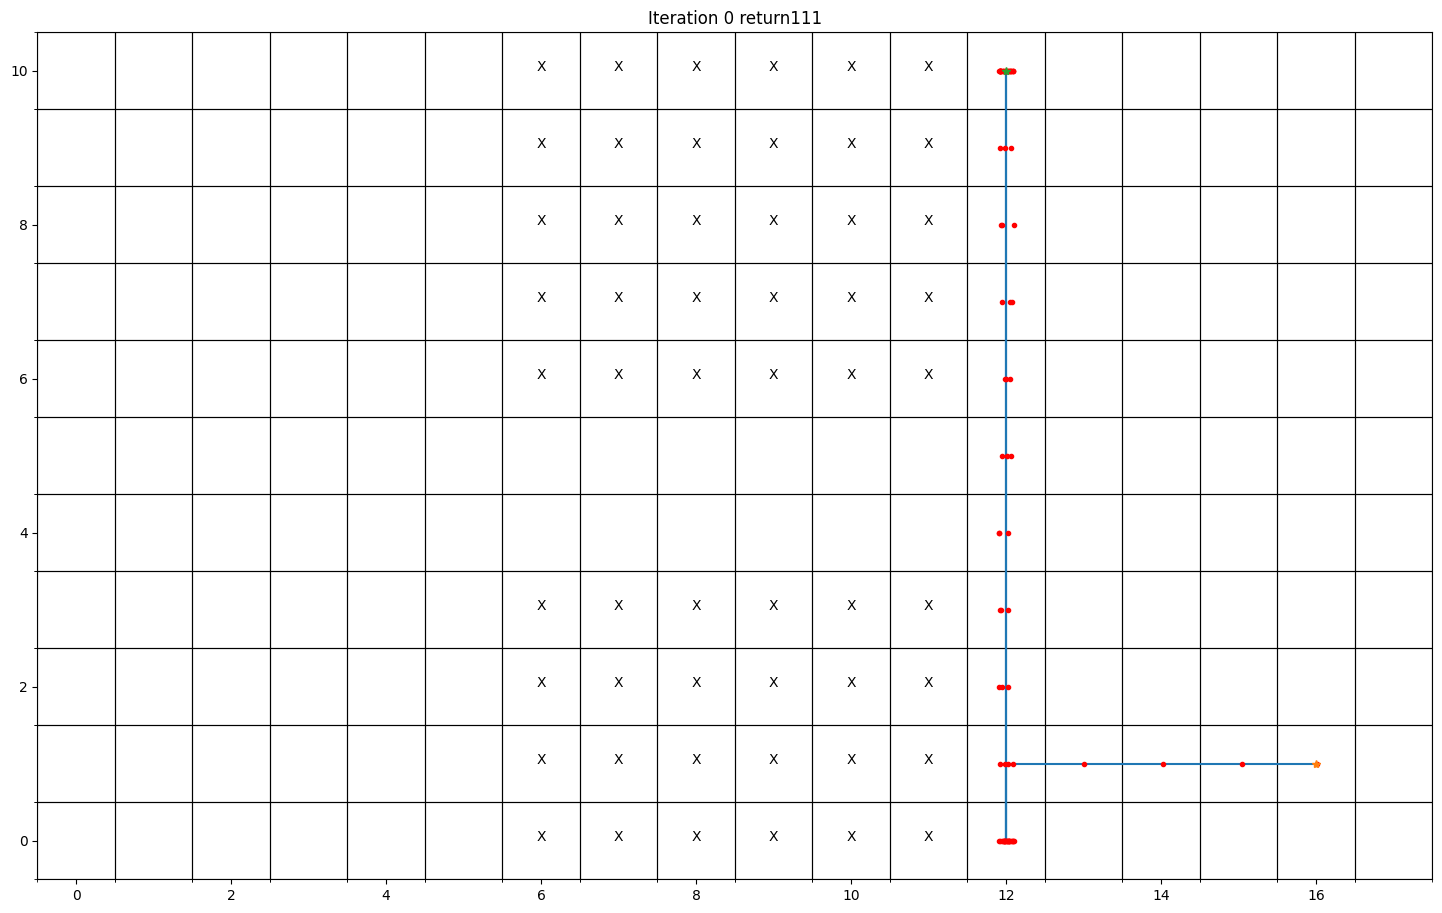

In [16]:
import importlib
import visualization
importlib.reload(visualization)
from visualization import Visu
visu = Visu(env_params=params["env"])
visu.visu_path(path,env.Hori_ActionTransitionMatrix)

In [17]:
min_return = []
max_return = []
mean_return = []
median_return = []
for iter in range(10):
    params["common"]["batch_size"]=1000
    mat_state = []
    mat_return = []
    env.initialize(params["env"]["initial"])
    mat_state.append(env.state)
    init_state = env.state
    for h_iter in range(H-1):
        batch_state = append_state(mat_state, H-1)
        probs = agent.actor(batch_state.to(device))
        actions_dist = torch.distributions.Categorical(probs)
        actions = actions_dist.sample()
        env.step(h_iter, actions)
        mat_state.append(env.state)  # s+1

    returns = env.weighted_traj_return(mat_state, type = params["alg"]["type"]).float()
    min_return.append(returns.min())
    max_return.append(returns.max())
    mean_return.append(returns.mean())
    median_return.append(returns.median())
mean_min_return = np.mean(min_return)
std_min_return = np.std(min_return)
mean_max_return = np.mean(max_return)
std_max_return = np.std(max_return)
mean_mean_return = np.mean(mean_return)
std_mean_return = np.std(mean_return)
mean_median_return = np.mean(median_return)
std_median_return = np.std(median_return)
print(f"min: {mean_min_return:.2f}±{std_min_return:.2f}, max: {mean_max_return:.2f}±{std_max_return:.2f}, mean: {mean_mean_return:.2f}±{std_mean_return:.2f}, median: {mean_median_return:.2f}±{std_median_return:.2f}")

min: 32.60±0.92, max: 48.00±0.00, mean: 44.61±0.07, median: 46.00±0.00
